# Installing Libraries

!pip install torch torchvision <br>
!pip install scikit-learn <br>
!pip install optuna <br>
!pip install lxml

```
!pip install optuna
```



https://www.kaggle.com/code/wonduk/pytorch-lstm-daily-climate-forecasting <br>
https://gist.github.com/rohithteja/821935e7c3c690bb424ab8e1edc59dec

# Importing Libraries and Dataset

In [ ]:
!pip install optuna
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support
import optuna
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.7 MB/s eta 0:00:00
Mounted at /content/drive


# Creating Dataset

In [ ]:
def create_loader(data):
    # Import Dataset
    # 'rainfall_df_' + data + '.csv'
    rainfall_df = pd.read_csv('/content/drive/MyDrive/Thesis_Data/rainfall_df_' + data + '.csv')
    rainfall_df.sort_values(by = ['Date', 'Time'], ascending = [1, 1], inplace = True)
    rainfall_df["datetime"] = pd.to_datetime(rainfall_df["Date"] + ' ' + rainfall_df["Time"], format = '%Y-%m-%d %H:%M:%S')
    rainfall_df.drop(['Date', 'Time'], axis = 1, inplace = True)
    rainfall_df['Rainfall (mm)'] = rainfall_df['Rainfall (mm)'].astype('float')
    rainfall_df.set_index('datetime', inplace=True)
    if data == 'cawang': rainfall_df = rainfall_df[rainfall_df.index > '2018-01-01']
    elif data == 'pasirjaya': rainfall_df.loc['2022-03-02':'2022-04-08','Rainfall (mm)'] = 0
    # Data Preprocessing
    rainfall_df = rainfall_df.reindex(pd.date_range(start = rainfall_df.index.min(), end = rainfall_df.index.max(), freq = 'h'))
    rainfall_df.loc[:, 'Rainfall (mm)'] = rainfall_df['Rainfall (mm)'].ffill()

    # Feature Engineering
    #rainfall_df.set_index('datetime', inplace = True)
    rainfall_df.index = pd.DatetimeIndex(rainfall_df.index)
    rainfall_df['year'] = rainfall_df.index.year
    rainfall_df['month'] = rainfall_df.index.month
    rainfall_df['day_of_year'] = rainfall_df.index.dayofyear
    rainfall_df['day'] = rainfall_df.index.day
    rainfall_df['hour'] = rainfall_df.index.hour
    rainfall_df['will_rain'] = (rainfall_df['Rainfall (mm)'] > 0).astype(int)

    # Cyclic Encoding
    for year in pd.unique(rainfall_df['year']):
        doy = rainfall_df[rainfall_df['year'] == year]['day_of_year']
        rainfall_df.loc[rainfall_df['year'] == year, 'doy_sin'] = np.sin(2 * np.pi * doy/doy.max())
        rainfall_df.loc[rainfall_df['year'] == year, 'doy_cos'] = np.cos(2 * np.pi * doy/doy.max())

        for month in pd.unique(rainfall_df['month']):
            day = rainfall_df[(rainfall_df['year'] == year) & (rainfall_df['month'] == month)]['day']
            rainfall_df.loc[(rainfall_df['year'] == year) & (rainfall_df['month'] == month), 'day_sin'] = np.sin(2 * np.pi * day/day.max())
            rainfall_df.loc[(rainfall_df['year'] == year) & (rainfall_df['month'] == month), 'day_cos'] = np.cos(2 * np.pi * day/day.max())

    rainfall_df['month_sin'] = np.sin(2 * np.pi * rainfall_df['month']/rainfall_df['month'].max())
    rainfall_df['month_cos'] = np.cos(2 * np.pi * rainfall_df['month']/rainfall_df['month'].max())
    rainfall_df['hour_sin'] = np.sin(2 * np.pi * rainfall_df['hour']/24)
    rainfall_df['hour_cos'] = np.cos(2 * np.pi * rainfall_df['hour']/24)
    rainfall_df.drop(['month', 'day_of_year', 'day', 'hour', 'year'], axis = 1, inplace = True)

    # Random seed for reproducibility
    torch.manual_seed(42)

    seq_length = 6 # Using the rainfall from the previous 6 hours to predict the rainfall of the next hour
    lookback = pd.Timedelta(hours = seq_length)
    if data == 'pasarbaru' or data == 'rancabungur': time = {'start': '2024-01-16', 'end': '2024-07-01'}
    elif data == 'situparigi' or data == 'lengkongbarang': time = {'start': '2024-12-01', 'end': '2025-01-01'}
    else: time = {'start': '2023-01-01', 'end': '2024-01-01'}

    train_data = rainfall_df[(rainfall_df.index >= pd.Timestamp('2017-01-01')) & (rainfall_df.index < pd.Timestamp(time['start']))]
    val_data = rainfall_df[(rainfall_df.index >= (pd.Timestamp(time['start']) - lookback)) & (rainfall_df.index < pd.Timestamp(time['end']))]
    test_data = rainfall_df[rainfall_df.index >= (pd.Timestamp(time['end']) - lookback)]

    # Scaling the values to a range of [0,1], useful for LSTM because it requires normalized data
    feature_scaler, target_reg_scaler, target_cls_scaler = MinMaxScaler(), MinMaxScaler(), MinMaxScaler()

    X_train = feature_scaler.fit_transform(train_data)
    y_train_reg = target_reg_scaler.fit_transform(train_data[['Rainfall (mm)']])
    X_val = feature_scaler.transform(val_data)
    y_val_reg = target_reg_scaler.transform(val_data[['Rainfall (mm)']])
    X_test = feature_scaler.transform(test_data)
    y_test_reg = target_reg_scaler.transform(test_data[['Rainfall (mm)']])

    # Create Sliding Window
    def create_sequences(X, y_reg, seq_length):
        sequences, reg_labels = [], []
        for i in range(len(y_reg) - seq_length):
            sequences.append(X[i:i + seq_length])
            reg_labels.append(y_reg[i + seq_length])
        return np.array(sequences), np.array(reg_labels)

    X_train, y_train_reg = create_sequences(X_train, y_train_reg, seq_length)
    X_val, y_val_reg = create_sequences(X_val, y_val_reg, seq_length)
    X_test, y_test_reg = create_sequences(X_test, y_test_reg, seq_length)

    # Convert to PyTorch tensors
    X_train, y_train_reg = torch.tensor(X_train, dtype = torch.float32), torch.tensor(y_train_reg, dtype = torch.float32)
    X_val, y_val_reg = torch.tensor(X_val, dtype = torch.float32), torch.tensor(y_val_reg, dtype = torch.float32)
    X_test, y_test_reg = torch.tensor(X_test, dtype = torch.float32), torch.tensor(y_test_reg, dtype = torch.float32)

    # Load the dataset
    batch_size = 32
    train_loader = DataLoader(TensorDataset(X_train, y_train_reg), batch_size = batch_size)
    val_loader = DataLoader(TensorDataset(X_val, y_val_reg), batch_size = batch_size)
    test_loader = DataLoader(TensorDataset(X_test, y_test_reg), batch_size = batch_size)

    return feature_scaler, target_reg_scaler, rainfall_df, X_train, train_loader, val_loader, test_loader, val_data, test_data

# Creating the LSTM Model

In [ ]:
# Define the ANN model
class RainfallLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout)
        self.fc_reg = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        reg_out = nn.ReLU()(self.fc_reg(hn[-1]))

        return reg_out

def safe_reg_loss(pred, target, rain_mask, weight, max_weight):
    pred = pred.squeeze()
    target = target.squeeze()
    rain_mask = rain_mask.squeeze().float()
    rainy_preds = pred[rain_mask == 1]
    rainy_targets = target[rain_mask == 1]
    num_rainy_samples = rainy_targets.numel()
    if num_rainy_samples < 1:
        return ((pred - target) ** 2).mean() * 0
    max_val = rainy_targets.max()
    if max_val < 1e-6:
        raw_weights = torch.ones_like(rainy_targets)
    else:
        raw_weights = weight + torch.clamp(rainy_targets / max_val, max = max_weight)
    reg_weights = raw_weights / raw_weights.mean()
    mse_per_sample = (rainy_preds - rainy_targets) ** 2
    weighted_mse_loss = torch.sum(reg_weights * mse_per_sample) / num_rainy_samples # Average over rainy samples
    return weighted_mse_loss

# Check if a GPU is available, otherwise use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Find the best binary threshold
def find_best_threshold(y_probs, y_true):
    best_threshold = 0.5
    best_f1 = 0.0

    thresholds = np.linspace(0, 1, 100)  # Test 100 thresholds between 0 and 1
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# Define the performance metrics
def perform_reg_metrics(target, output, threshold = None):
    if threshold is not None:
        if threshold == 0: masking = (target > threshold)
        else: masking = (target >= threshold)
        target = target[masking]
        output = output[masking]
    mse = mean_squared_error(target, output)
    rmse = mse**.5
    mae = mean_absolute_error(target, output)
    r2 = r2_score(target, output)

    return mse, rmse, mae, r2

def perform_cls_metrics(target, output, threshold = None):
    if threshold is not None:
        target = (target >= threshold).astype(int)
        output = (output >= threshold).astype(int)
    else:
        target = (target > 0).astype(int)
        output = (output > 0).astype(int)
    accuracy = accuracy_score(target, output)
    precision = precision_score(target, output, zero_division = 0)
    recall = recall_score(target, output, zero_division = 0)
    f1 = f1_score(target, output)
    confusion = confusion_matrix(target, output)
    tn, fp, fn, tp = confusion.ravel()

    return accuracy, precision, recall, f1, tn, fp, fn, tp

def print_metrics(metrics_cls, metrics_reg, rain_reg, extreme_cls, extreme_reg):
    print(
        f"\tCls Accuracy: {metrics_cls[0]:.4f}, "
        f"Cls Precision: {metrics_cls[1]:.4f}, "
        f"Cls Recall: {metrics_cls[2]:.4f}, "
        f"Cls F1 Score: {metrics_cls[3]:.4f}\n\t"
        f"Reg MSE: {metrics_reg[0]:.4f}, "
        f"Reg RMSE: {metrics_reg[1]:.4f}, "
        f"Reg MAE: {metrics_reg[2]:.4f}, "
        f"Reg R2 Score: {metrics_reg[3]:.4f}\n\t"
        f"Rain MSE: {rain_reg[0]:.4f}, "
        f"Rain RMSE: {rain_reg[1]:.4f}, "
        f"Rain MAE: {rain_reg[2]:.4f}, "
        f"Rain R2 Score: {rain_reg[3]:.4f}\n\t"
        f"Extreme Accuracy: {extreme_cls[0]:.4f}, "
        f"Extreme Precision: {extreme_cls[1]:.4f}, "
        f"Extreme Recall: {extreme_cls[2]:.4f}, "
        f"Extreme F1 Score: {extreme_cls[3]:.4f}\n\t"
        f"Extreme MSE: {extreme_reg[0]:.4f}, "
        f"Extreme RMSE: {extreme_reg[1]:.4f}, "
        f"Extreme MAE: {extreme_reg[2]:.4f}, "
        f"Extreme R2 Score: {extreme_reg[3]:.4f}"
    )

# "sqlite:///cawang_study.db"
# 'pred_sum_' + name + '.xlsx'

def save_tuning(num_trials, fixed_params, hyperparam, metrics, df, name):
    with pd.ExcelWriter(
        '/content/drive/MyDrive/Thesis_Data/pred_sum_' + name + '_reg.xlsx',
        engine = 'openpyxl',
        mode = 'a',
        if_sheet_exists = 'overlay'
    ) as writer:
        pd.DataFrame.from_dict({'num_trials': num_trials, 'epoch': fixed_params['epochs'], 'rain_weight': fixed_params['rain_weight']}, orient = 'index').to_excel(writer, sheet_name = name, index = False, header = False, startrow = 2, startcol = 2)
        pd.DataFrame.from_dict([fixed_params['size_range'], fixed_params['layer_range'], fixed_params['dropout_range'], fixed_params['lr_range']]).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 8, startcol = 2)
        pd.DataFrame.from_dict(hyperparam, orient = 'index').to_excel(writer, sheet_name = name, index = False, header = False, startrow = 8, startcol = 4)
        pd.DataFrame.from_dict(metrics, orient = 'index').to_excel(writer, sheet_name = name, index = False, header = False, startrow = 14, startcol = 2)
        df.to_excel(writer, sheet_name = name + '_tuning', index = False, header = True, startrow = 2, startcol = 1)

def save_val(val_reg_targets, val_reg_outputs, metrics, rain_metrics, extreme_metrics, name):
    with pd.ExcelWriter(
        '/content/drive/MyDrive/Thesis_Data/pred_sum_' + name + '_reg.xlsx',
        engine = 'openpyxl',
        mode = 'a',
        if_sheet_exists = 'overlay'
    ) as writer:
        pd.DataFrame(metrics).to_excel(writer, sheet_name = name, index = True, header = False, startrow = 10, startcol = 8)
        pd.DataFrame(rain_metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 10, startcol = 26)
        pd.DataFrame(extreme_metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 10, startcol = 31)
        pd.DataFrame({
        'Val reg target': val_reg_targets.flatten(),
        'Val reg output': val_reg_outputs.flatten()
    }, index = val_data_ori.iloc[6:].index).to_excel(writer, sheet_name = name, index = True, header = False, startrow = 4, startcol = 44)

def save_test(test_reg_targets, test_reg_outputs, metrics, rain_metrics, extreme_metrics, name):
    with pd.ExcelWriter(
        '/content/drive/MyDrive/Thesis_Data/pred_sum_' + name + '_reg.xlsx',
        engine = 'openpyxl',
        mode = 'a',
        if_sheet_exists = 'overlay'
    ) as writer:
        pd.DataFrame(metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 4, startcol = 11)
        pd.DataFrame(rain_metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 4, startcol = 26)
        pd.DataFrame(extreme_metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 4, startcol = 31)
        pd.DataFrame({
        'Test reg target': test_reg_targets.flatten(),
        'test reg output': test_reg_outputs.flatten()
    }, index = test_data_ori.iloc[6:].index).to_excel(writer, sheet_name = name, index = True, header = False, startrow = 4, startcol = 49)

In [ ]:
def objective(trial, size_range, layer_range, dropout_range, lr_range, epochs, rain_weight):
    # Define hyperparameters to tune
    hidden_size = trial.suggest_int('hidden_size', size_range[0], size_range[1])
    num_layers = trial.suggest_int('num_layers', layer_range[0], layer_range[1])
    dropout = trial.suggest_float('dropout', dropout_range[0], dropout_range[1])
    learning_rate = trial.suggest_float('lr', lr_range[0], lr_range[1], log = True)

    # Create model
    model = RainfallLSTM(
        input_size = X_train.shape[2],
        hidden_size = hidden_size,
        num_layers = num_layers,
        dropout = dropout
    )
    model.to(device)

    reg_criterion = nn.MSELoss()
    extreme_thresh = 20
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)

    best_val_loss = float('inf')
    best_metrics = {}

    for epoch in range(epochs + 1):  # Training and validation happens within 1 epoch
        # Training
        model.train()
        train_loss_reg = 0.0
        train_loss_total = 0.0
        total_train_samples = 0
        count = 0

        for train_data, train_reg_target in train_loader:
            train_data, train_reg_target = train_data.to(device), train_reg_target.to(device)
            optimizer.zero_grad()
            rain_mask = (train_reg_target > 0).float()
            train_reg_output = model(train_data)
            reg_loss = safe_reg_loss(train_reg_output, train_reg_target, rain_mask, 1, 20)
            loss = reg_loss
            loss.backward()
            optimizer.step()

            train_loss_reg += reg_loss.item() * train_data.size(0)
            train_loss_total += loss.item() * train_data.size(0)
            total_train_samples += train_data.size(0)

        train_loss_reg /= total_train_samples
        train_loss_total /= total_train_samples

        # Validation
        model.eval()
        val_loss_reg = 0.0
        val_loss_total = 0.0
        total_val_samples = 0
        val_reg_outputs = []
        val_reg_targets = []

        with torch.no_grad():
            for val_data, val_reg_target in val_loader:
                val_data, val_reg_target = val_data.to(device), val_reg_target.to(device)
                val_reg_output = model(val_data)
                reg_loss = reg_criterion(val_reg_output, val_reg_target)
                loss = reg_loss
                val_loss_reg += reg_loss.item() * val_data.size(0)
                val_loss_total += loss.item() * val_data.size(0)
                total_val_samples += val_data.size(0)

                val_reg_outputs.append(val_reg_output)
                val_reg_targets.append(val_reg_target)

            val_loss_reg /= total_val_samples
            val_loss_total /= total_val_samples

        val_reg_targets = target_reg_scaler.inverse_transform(torch.cat(val_reg_targets).cpu().numpy().reshape(-1, 1))
        val_reg_outputs = target_reg_scaler.inverse_transform(torch.cat(val_reg_outputs).cpu().numpy().reshape(-1, 1))

        metrics_cls = perform_cls_metrics(val_reg_targets, val_reg_outputs)
        metrics_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs)
        rain_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 0)
        extreme_cls = perform_cls_metrics(val_reg_targets, val_reg_outputs, 20)
        extreme_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 20)

        if val_loss_total < best_val_loss:
            best_metrics.update({
                'epoch': epoch,
                'train_loss_total': train_loss_total,
                'train_loss_reg': train_loss_reg,
                'val_loss_total': val_loss_total,
                'val_loss_reg': val_loss_reg,
                'Accuracy': metrics_cls[0],
                'Precision': metrics_cls[1],
                'Recall': metrics_cls[2],
                'F1': metrics_cls[3],
                'MSE Reg': metrics_reg[0],
                'RMSE Reg': metrics_reg[1],
                'MAE Reg': metrics_reg[2],
                'R2 Reg': metrics_reg[3],
                'MSE Rain': rain_reg[0],
                'RMSE Rain': rain_reg[1],
                'MAE Rain': rain_reg[2],
                'R2 Rain': rain_reg[3],
                'MSE Extreme': extreme_reg[0],
                'RMSE Extreme': extreme_reg[1],
                'MAE Extreme': extreme_reg[2],
                'R2 Extreme': extreme_reg[3],
                'Accuracy Extreme': extreme_cls[0],
                'Precision Extreme': extreme_cls[1],
                'Recall Extreme': extreme_cls[2],
                'F1 Extreme': extreme_cls[3]
            })
            best_val_loss = val_loss_total

        # Report the validation loss and metrics for Optuna
        trial.set_user_attr('Best epoch', best_metrics['epoch'])
        trial.set_user_attr('train_loss_total', best_metrics['train_loss_total'])
        trial.set_user_attr('train_loss_reg', best_metrics['train_loss_reg'])
        trial.set_user_attr('val_loss_total', best_metrics['val_loss_total'])
        trial.set_user_attr('val_loss_reg', best_metrics['val_loss_reg'])
        trial.set_user_attr('Accuracy', best_metrics['Accuracy'])
        trial.set_user_attr('Precision', best_metrics['Precision'])
        trial.set_user_attr('Recall', best_metrics['Recall'])
        trial.set_user_attr('F1', best_metrics['F1'])
        trial.set_user_attr('MSE Reg', best_metrics['MSE Reg'])
        trial.set_user_attr('RMSE Reg', best_metrics['RMSE Reg'])
        trial.set_user_attr('MAE Reg', best_metrics['MAE Reg'])
        trial.set_user_attr('R2 Reg', best_metrics['R2 Reg'])
        trial.set_user_attr('MSE Rain', best_metrics['MSE Rain'])
        trial.set_user_attr('RMSE Rain', best_metrics['RMSE Rain'])
        trial.set_user_attr('MAE Rain', best_metrics['MAE Rain'])
        trial.set_user_attr('R2 Rain', best_metrics['R2 Rain'])
        trial.set_user_attr('MSE Extreme', best_metrics['MSE Extreme'])
        trial.set_user_attr('RMSE Extreme', best_metrics['RMSE Extreme'])
        trial.set_user_attr('MAE Extreme', best_metrics['MAE Extreme'])
        trial.set_user_attr('R2 Extreme', best_metrics['R2 Extreme'])
        trial.set_user_attr('Accuracy Extreme', best_metrics['Accuracy Extreme'])
        trial.set_user_attr('Precision Extreme', best_metrics['Precision Extreme'])
        trial.set_user_attr('Recall Extreme', best_metrics['Recall Extreme'])
        trial.set_user_attr('F1 Extreme', best_metrics['F1 Extreme'])
        trial.report(best_metrics['val_loss_total'], epoch)

        # Prune the trial if it is not promising
        #if trial.should_prune():
        #    raise optuna.exceptions.TrialPruned()

    return best_val_loss

# Villa Pamulang

In [ ]:
name = 'pamulang'
feature_scaler, target_reg_scaler, rainfall_df, X_train, train_loader, val_loader, test_loader, val_data_ori, test_data_ori = create_loader(name)

In [ ]:
val_data_ori

,Rainfall (mm),will_rain,doy_sin,doy_cos,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos
2024-11-30 18:00:00,0.0,0,-5.074151e-01,0.861702,-1.133108e-15,1.0,-5.000000e-01,0.866025,-1.000000,-1.836970e-16
2024-11-30 19:00:00,0.0,0,-5.074151e-01,0.861702,-1.133108e-15,1.0,-5.000000e-01,0.866025,-0.965926,2.588190e-01
2024-11-30 20:00:00,0.0,0,-5.074151e-01,0.861702,-1.133108e-15,1.0,-5.000000e-01,0.866025,-0.866025,5.000000e-01
2024-11-30 21:00:00,0.0,0,-5.074151e-01,0.861702,-1.133108e-15,1.0,-5.000000e-01,0.866025,-0.707107,7.071068e-01
2024-11-30 22:00:00,0.0,0,-5.074151e-01,0.861702,-1.133108e-15,1.0,-5.000000e-01,0.866025,-0.500000,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,0.0,0,-2.449294e-16,1.000000,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.965926,2.588190e-01
2024-12-31 20:00:00,0.0,0,-2.449294e-16,1.000000,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.866025,5.000000e-01
2024-12-31 21:00:00,0.0,0,-2.449294e-16,1.000000,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.707107,7.071068e-01
2024-12-31 22:00:00,0.0,0,-2.449294e-16,1.000000,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.500000,8.660254e-01


In [ ]:
# Optimize Hyperparameters
fixed_params = {'size_range': [16, 64], 'layer_range': [1, 3], 'dropout_range': [0.1, 0.2], 'lr_range': [1e-4, 1e-2], 'epochs': 20, 'rain_weight': 5}
num_trials = 10
storage_path = "sqlite:////content/drive/MyDrive/Thesis_Data/le_study.db"
'''
try:
    storage = optuna.storages.RDBStorage(url=storage_path)
    optuna.delete_study(study_name = name + "_study", storage=storage)
    print("Deleted existing study")
except KeyError:
    print("No existing study")
'''
study = optuna.create_study(
    study_name = name + "_reg_study",
    direction="minimize",
    storage=storage_path,
    load_if_exists=True
)
remaining_trials = num_trials - len(study.trials)
study.optimize(lambda trial: objective(trial, **fixed_params), n_trials = remaining_trials)

print("Best hyperparameters:", study.best_trial.params)
print("Best validation loss:", study.best_trial.value)
for key, value in study.best_trial.user_attrs.items():
    print(f"Best {key}: {value:.4f}")

[I 2025-06-16 17:00:50,030] Using an existing study with name 'pamulang_reg_study' instead of creating a new one.


Best hyperparameters: {'hidden_size': 43, 'num_layers': 1, 'dropout': 0.16849453444657486, 'lr': 0.0011246350172159148}
Best validation loss: 0.0008266987503150352
Best Accuracy: 0.9458
Best Accuracy Extreme: 0.9966
Best Best epoch: 0.0000
Best F1: 0.0000
Best F1 Extreme: 0.0000
Best MAE Extreme: 31.9500
Best MAE Rain: 4.6779
Best MAE Reg: 0.2537
Best MSE Extreme: 1176.4083
Best MSE Rain: 96.3589
Best MSE Reg: 5.2249
Best Precision: 0.0000
Best Precision Extreme: 0.0000
Best R2 Extreme: -6.5602
Best R2 Rain: -0.2938
Best R2 Reg: -0.0125
Best RMSE Extreme: 34.2988
Best RMSE Rain: 9.8163
Best RMSE Reg: 2.2858
Best Recall: 0.0000
Best Recall Extreme: 0.0000
Best train_loss_reg: 0.0095
Best train_loss_total: 0.0095
Best val_loss_reg: 0.0008
Best val_loss_total: 0.0008


In [ ]:
all_trials_data = []

for trial in study.trials:
    trial_info = {"trial_number": trial.number}
    trial_info.update(trial.params)      # Optionally include hyperparameters
    trial_info.update(trial.user_attrs)  # Add all user_attr values
    all_trials_data.append(trial_info)

df = pd.DataFrame(all_trials_data)
save_tuning(num_trials, fixed_params, study.best_trial.params, study.best_trial.user_attrs, df, name)

In [ ]:
best_params = study.best_params

model = RainfallLSTM(
    input_size = X_train.shape[2],
    hidden_size = best_params['hidden_size'],
    num_layers = best_params['num_layers'],
    dropout = best_params['dropout']
)

# Define the loss function and optimizer
reg_criterion = nn.MSELoss()
extreme_thresh = 20
optimizer = optim.Adam(model.parameters(), lr = best_params['lr'])
model.to(device)

num_epochs = 100
best_val_loss = float('inf')
all_train_loss = []
all_val_loss = []
metrics, rain_metrics, extreme_metrics = [], [], []

for epoch in range(num_epochs + 1): # Training and validation happens within 1 epoch
    # Training
    model.train() # Put the environment in training mode
    train_loss_reg = 0.0
    train_loss_total = 0.0
    total_train_samples = 0
    count = 0
    for train_data, train_reg_target in train_loader:
        train_data, train_reg_target = train_data.to(device), train_reg_target.to(device)
        optimizer.zero_grad()
        train_reg_output = model(train_data)
        rain_mask = (train_reg_target > 0).float()  # Mask where 'will_rain' is 1 (rain is expected)
        reg_loss = safe_reg_loss(train_reg_output, train_reg_target, rain_mask, 1, 10)
        loss = reg_loss
        loss.backward()
        optimizer.step()

        # Accumulate loss for logging
        train_loss_reg += reg_loss.item() * train_data.size(0)
        train_loss_total += loss.item() * train_data.size(0)
        total_train_samples += train_data.size(0)

    # Calculate average training loss for the epoch
    train_loss_reg /= total_train_samples
    train_loss_total /= total_train_samples

    # Validation
    model.eval() # Put the environment in evaluation mode (for validation and testing)
    val_loss_reg = 0.0
    val_loss_total = 0.0
    total_val_samples = 0
    val_reg_outputs = []
    val_reg_targets = []

    with torch.no_grad(): # Temporarily disables gradient tracking
        for val_data, val_reg_target in val_loader:
            val_data, val_reg_target = val_data.to(device), val_reg_target.to(device)
            val_reg_output = model(val_data)
            rain_mask = (val_reg_target > 0)  # Mask where 'will_rain' is 1 (rain is expected)
            reg_loss = reg_criterion(val_reg_output, val_reg_target)
            loss = reg_loss

            # Accumulate the loss for monitoring
            val_loss_reg += reg_loss.item() * val_data.size(0)
            val_loss_total += loss.item() * val_data.size(0)
            total_val_samples += val_data.size(0)

            # Store outputs for performance metrics
            val_reg_outputs.append(val_reg_output)
            val_reg_targets.append(val_reg_target)

        # Calculate average validation loss for the epoch
        val_loss_reg /= total_val_samples
        val_loss_total /= total_val_samples

    # Inverse transform for regression
    val_reg_targets = target_reg_scaler.inverse_transform(torch.cat(val_reg_targets).cpu().numpy().reshape(-1, 1))
    val_reg_outputs = target_reg_scaler.inverse_transform(torch.cat(val_reg_outputs).cpu().numpy().reshape(-1, 1))

    # Performance metrics
    metrics_cls = perform_cls_metrics(val_reg_targets, val_reg_outputs)
    metrics_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs)
    rain_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 0)
    extreme_cls = perform_cls_metrics(val_reg_targets, val_reg_outputs, 20)
    extreme_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 20)
    metrics.append((train_loss_reg, val_loss_reg) + metrics_reg + metrics_cls)
    rain_metrics.append(rain_reg)
    extreme_metrics.append((extreme_reg + extreme_cls))

    all_train_loss.append((train_loss_reg))
    all_val_loss.append((val_loss_reg))

    if epoch % 20 == 0:
        print(f"Epoch [{epoch}/{num_epochs}]\n\t"
        f"Train Loss (REG): {train_loss_reg:.4f}, "
        f"Val Loss (REG): {val_loss_reg:.4f}")
        print_metrics(metrics_cls, metrics_reg, rain_reg, extreme_cls, extreme_reg)

    if val_loss_total < best_val_loss: # Choose the model with the lowest validation loss for testing
        best_val_loss = val_loss_total
        best_model_state = model.state_dict()

model.load_state_dict(best_model_state)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16849453444657486 and num_layers=1
  warnings.warn(


Epoch [0/100]
	Train Loss (REG): 0.0073, Val Loss (REG): 0.0019
	Cls Accuracy: 0.1237, Cls Precision: 0.0563, Cls Recall: 0.9621, Cls F1 Score: 0.1064
	Reg MSE: 11.9461, Reg RMSE: 3.4563, Reg MAE: 2.5420, Reg R2 Score: -1.3149
	Rain MSE: 72.6135, Rain RMSE: 8.5214, Rain MAE: 4.3187, Rain R2 Score: 0.0250
	Extreme Accuracy: 0.9966, Extreme Precision: 0.0000, Extreme Recall: 0.0000, Extreme F1 Score: 0.0000
	Extreme MSE: 924.6646, Extreme RMSE: 30.4083, Extreme MAE: 27.8616, Extreme R2 Score: -4.9424
Epoch [20/100]
	Train Loss (REG): 0.0066, Val Loss (REG): 0.0036
	Cls Accuracy: 0.1121, Cls Precision: 0.0532, Cls Recall: 0.9158, Cls F1 Score: 0.1006
	Reg MSE: 22.7845, Reg RMSE: 4.7733, Reg MAE: 3.7577, Reg R2 Score: -3.4151
	Rain MSE: 67.5667, Rain RMSE: 8.2199, Rain MAE: 4.7914, Rain R2 Score: 0.0928
	Extreme Accuracy: 0.9966, Extreme Precision: 0.0000, Extreme Recall: 0.0000, Extreme F1 Score: 0.0000
	Extreme MSE: 781.8087, Extreme RMSE: 27.9608, Extreme MAE: 25.0742, Extreme R2 Score:

<All keys matched successfully>

In [ ]:
torch.save(best_model_state, '/content/drive/MyDrive/Thesis_Data/best_' + name + '_reg.pth')

In [ ]:
save_val(val_reg_targets, val_reg_outputs, metrics, rain_metrics, extreme_metrics, name)

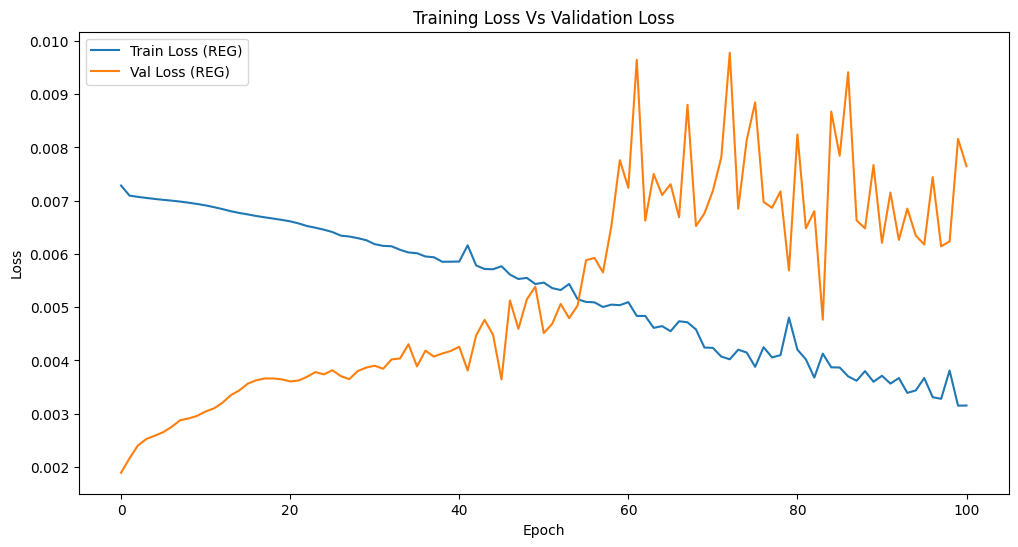

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(range(0, num_epochs + 1), [item for item in all_train_loss], label = 'Train Loss (REG)')
plt.plot(range(0, num_epochs + 1), [item for item in all_val_loss], label = 'Val Loss (REG)')

plt.title('Training Loss Vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
best_params = study.best_params

model = RainfallLSTM(
    input_size = X_train.shape[2],
    hidden_size = best_params['hidden_size'],
    num_layers = best_params['num_layers'],
    dropout = best_params['dropout']
)
model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis_Data/best_' + name + '_reg.pth'))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16849453444657486 and num_layers=1
  warnings.warn(


<All keys matched successfully>

In [ ]:
# Validation set evaluation
date = []
targets = []
predictions = []
total_val_samples = 0
val_loss_reg = 0
val_loss_total = 0
val_reg_outputs = []
val_reg_targets = []
val_metrics = []
val_rain_metrics = []
val_extreme_metrics = []
reg_criterion = nn.MSELoss()

model.eval()
with torch.no_grad():
    for val_data, val_reg_target in val_loader:
        val_data, val_reg_target = val_data.to(device), val_reg_target.to(device)
        val_reg_output = model(val_data)
        reg_loss = reg_criterion(val_reg_output, val_reg_target)
        loss = reg_loss

        # Accumulate the loss for monitoring
        val_loss_reg += reg_loss.item() * val_data.size(0)
        val_loss_total += loss.item() * val_data.size(0)
        total_val_samples += val_data.size(0)

        # Store outputs for performance metrics
        val_reg_outputs.append(val_reg_output)
        val_reg_targets.append(val_reg_target)

    # Calculate average validation loss for the epoch
    val_loss_reg /= total_val_samples
    val_loss_total /= total_val_samples

# Inverse transform for regression
val_reg_targets = target_reg_scaler.inverse_transform(torch.cat(val_reg_targets).cpu().numpy().reshape(-1, 1))
val_reg_outputs = target_reg_scaler.inverse_transform(torch.cat(val_reg_outputs).cpu().numpy().reshape(-1, 1))

# Performance metrics
val_metrics_cls = perform_cls_metrics(val_reg_targets, val_reg_outputs)
val_metrics_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs)
val_rain_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 0)
val_extreme_cls = perform_cls_metrics(val_reg_targets, val_reg_outputs, 20)
val_extreme_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 20)
val_metrics.append((val_loss_reg,) + (val_metrics_reg))
val_rain_metrics.append(val_rain_reg)
val_extreme_metrics.append((val_extreme_reg))
save_val(val_reg_targets, val_reg_outputs, val_metrics, val_rain_metrics, val_extreme_metrics, name)

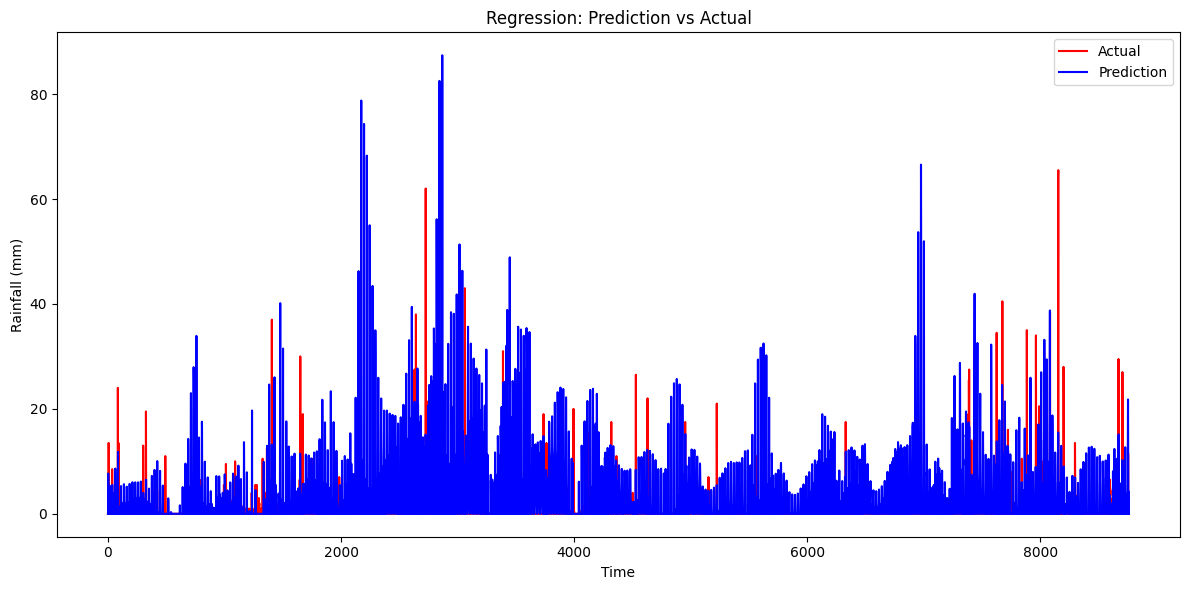

In [ ]:
start_range = 0
end_range = len(val_reg_outputs)
plt.figure(figsize = (12,6))
plt.plot(range(end_range - start_range), val_reg_targets[start_range:end_range], 'r', label='Actual')
plt.plot(range(end_range - start_range), val_reg_outputs[start_range:end_range], 'b', label='Prediction')
plt.title('Regression: Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Rainfall (mm)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing set evaluation
date = []
targets = []
predictions = []
total_test_samples = 0
test_loss_reg = 0
test_loss_total = 0
test_reg_outputs = []
test_reg_targets = []
test_metrics = []
test_rain_metrics = []
test_extreme_metrics = []

model.eval()
with torch.no_grad():
    for test_data, test_reg_target in test_loader:
        test_data, test_reg_target = test_data.to(device), test_reg_target.to(device)
        test_reg_output = model(test_data)
        reg_loss = reg_criterion(test_reg_output, test_reg_target)
        loss = reg_loss

        # Accumulate the loss for monitoring
        test_loss_reg += reg_loss.item() * test_data.size(0)
        test_loss_total += loss.item() * test_data.size(0)
        total_test_samples += test_data.size(0)

        # Store outputs for performance metrics
        test_reg_outputs.append(test_reg_output)
        test_reg_targets.append(test_reg_target)

    # Calculate average validation loss for the epoch
    test_loss_reg /= total_test_samples
    test_loss_total /= total_test_samples

# Inverse transform for regression
test_reg_targets = target_reg_scaler.inverse_transform(torch.cat(test_reg_targets).cpu().numpy().reshape(-1, 1))
test_reg_outputs = target_reg_scaler.inverse_transform(torch.cat(test_reg_outputs).cpu().numpy().reshape(-1, 1))

# Performance metrics
test_metrics_cls = perform_cls_metrics(test_reg_targets, test_reg_outputs)
test_metrics_reg = perform_reg_metrics(test_reg_targets, test_reg_outputs)
test_rain_reg = perform_reg_metrics(test_reg_targets, test_reg_outputs, 0)
test_extreme_cls = perform_cls_metrics(test_reg_targets, test_reg_outputs, 20)
test_extreme_reg = perform_reg_metrics(test_reg_targets, test_reg_outputs, 20)
test_metrics.append((test_loss_reg,) + (test_metrics_reg))
test_rain_metrics.append(rain_reg)
test_extreme_metrics.append((test_extreme_reg))
save_test(test_reg_targets, test_reg_outputs, test_metrics, test_rain_metrics, test_extreme_metrics, name)

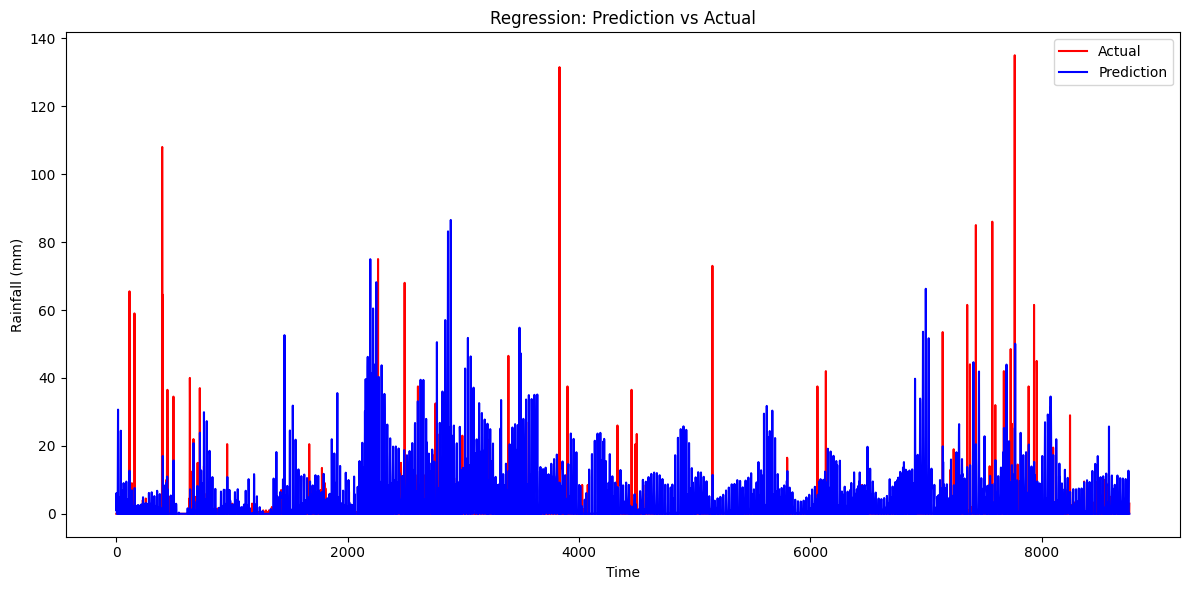

In [ ]:
start_range = 0
end_range = len(val_reg_outputs)
plt.figure(figsize = (12,6))
plt.plot(range(end_range - start_range), test_reg_targets[start_range:end_range], 'r', label='Actual')
plt.plot(range(end_range - start_range), test_reg_outputs[start_range:end_range], 'b', label='Prediction')
plt.title('Regression: Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Rainfall (mm)')
plt.legend()

plt.tight_layout()
plt.show()